In [1]:
import sys
sys.path.append("C:/Users/cnava/Repos/PolaPy")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.ticker as mtick

from polapy.competitiveness import blais_lago, endersby_etal, grofman_selb, navarrete_etal as nav_competition
from polapy.polarization import navarrete_etal as nav_polarization, esteban_ray


In [2]:
np.ceil(2)

2.0

In [3]:
mean = 75
rng = 25
# 99.73% chance the sample will fall in your desired range

In [4]:
list(range(0, 51, 5))

[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

In [5]:
def prepare_data(mean, stdev, candidate="A", N_units=50):
    output = np.asarray([np.floor(x) for x in np.random.normal(mean, stdev, N_units)])
    output[output < 0] = 0
    output[output > 100] = 100

    output = pd.DataFrame(output, columns=["votes"])
    output["unit"] = [x + 1 for x in range(output.shape[0])]
    output["candidate"] = candidate
    return output


candidates = "ABCDEF"
elections = []

election_id = 1
for share in range(50, 101):
    for x in [
        ([share, 100 - share], [0, 5, 10, 15, 20, 25]),
    ]:
        for stddev in x[1]:
            for iteration in range(30):
                output = []
                for i, score in enumerate(x[0]):
                    output.append(prepare_data(mean=score, stdev=stddev/3, candidate=candidates[i]))

                frag = pd.concat(output).sort_values("unit")
                frag["share"] = frag.groupby(["unit"], group_keys=False)["votes"].apply(lambda x: x/x.sum())
                frag["election_id"] = election_id

                election_id += 1

                elections.append(frag)

df = pd.concat(elections, ignore_index=True)
df.head()

,votes,unit,candidate,share,election_id
0,50.0,1,A,0.5,1
1,50.0,1,B,0.5,1
2,50.0,2,A,0.5,1
3,50.0,2,B,0.5,1
4,50.0,3,A,0.5,1


In [6]:
data = df.groupby(["election_id", "candidate"]).agg({"votes": "sum"})
data["share"] = data.groupby(level=[0], group_keys=False).apply(lambda x: x/x.sum())
data = data.unstack().reset_index()
data["margin_of_victory"] = np.abs(data[("share", "A")] - data[("share", "B")])
data = data[["election_id", "margin_of_victory"]].reset_index(drop=True)
data.columns = ["election_id", "margin_of_victory"]

data = pd.merge(data, df.groupby("election_id").agg({"share": "std"}).reset_index(), on="election_id")
data.head()

,election_id,margin_of_victory,share
0,1,0.0,0.0
1,2,0.0,0.0
2,3,0.0,0.0
3,4,0.0,0.0
4,5,0.0,0.0


In [7]:
df

,votes,unit,candidate,share,election_id
0,50.0,1,A,0.500000,1
1,50.0,1,B,0.500000,1
2,50.0,2,A,0.500000,1
3,50.0,2,B,0.500000,1
4,50.0,3,A,0.500000,1
...,...,...,...,...,...
917995,93.0,48,A,1.000000,9180
917996,4.0,49,B,0.038462,9180
917997,100.0,49,A,0.961538,9180
917998,95.0,50,A,0.969388,9180


In [8]:
output = []
for i, frag in df.groupby("election_id"):
    ep, ag = nav_polarization(frag)
    ec, ag = nav_competition(frag)
    output.append({
        "election_id": i,
        "ep": ep,
        "ec": ec
    })

df_scores = pd.DataFrame(output)
df_scores.head()

,election_id,ep,ec
0,1,0.0,1.0
1,2,0.0,1.0
2,3,0.0,1.0
3,4,0.0,1.0
4,5,0.0,1.0


In [9]:
data = pd.merge(data, df_scores, on="election_id")
data.head()

,election_id,margin_of_victory,share,ep,ec
0,1,0.0,0.0,0.0,1.0
1,2,0.0,0.0,0.0,1.0
2,3,0.0,0.0,0.0,1.0
3,4,0.0,0.0,0.0,1.0
4,5,0.0,0.0,0.0,1.0


In [10]:
n = 7

data["margin_of_victory_b"] = pd.qcut(data["margin_of_victory"], n).apply(lambda x: f"{np.round(x.mid * 100, 2)}%")
data["share_b"] = pd.qcut(data["share"], n).apply(lambda x: f"{np.round(x.mid * 100, 2)}%")
m = data.groupby(["margin_of_victory_b", "share_b"]).agg({"ec": "mean", "ep": "mean"}).reset_index()

<AxesSubplot: xlabel='margin_of_victory_b', ylabel='ec'>

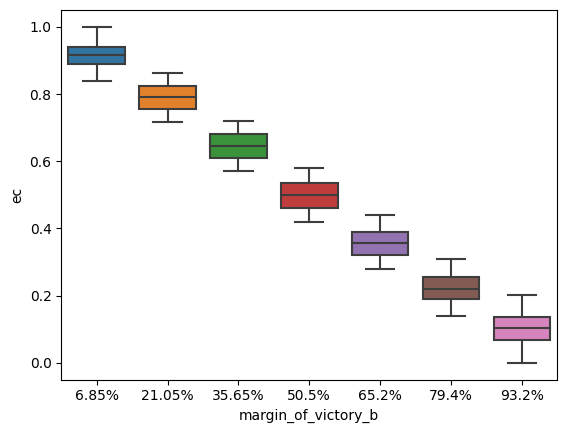

In [11]:
sns.boxplot(x="margin_of_victory_b", y="ec", data=data)